In [50]:
import subprocess
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

In [51]:
#Load the matrix containing the info about CV values and energy (FES).
#This file is usually the output of a plumed sum_hills analysis.
#The matrix is processed and stored in a format suitable for the next steps of the analysis.
def read_file(file):
    f = open(file, "r")
    data = []
    for i in f: #iterates through all the lines of f
        if "#!" not in i and i != "\n": #if the line is not empty, save it into the array
            row=i.split(" ") #data contained in the line is splitted according to the spacing of the file
            row = [ a for a in row if a != "" ] #changes the row in a list and clean it from empty fields
            row = [ a.rstrip("\n") for a in row ] #removes trailing new lines
            row = [float(a) for a in row] #changes type of the data
            data.append(row)

    return data

In [52]:
#Data is converted to a pandas dataframe for ease of usage.
#The column list contains the names for the column of the pandas dataframe.
#The number of names should match the amount of columns present in the original file.
def prep_data(data):
    column = ["dist", "torsion", "free_energy", "der_dist", "der_torsion"]
    grid = pd.DataFrame(data, columns=column)

    #Values of the CVs are taken from the dataframe and redudancies are filtered out.
    #The values are then stored in an array which will be used by the algorithm.
    #Each CV should have a dedicated array!
    dist = pd.DataFrame(grid['dist'], columns=['dist']) #takes the CV values from the dataframe; the name of the CV must match the name of the column previously provided to the dataframe.
    dist = dist.drop_duplicates(subset='dist') #drops duplicated in the values of the CV.
    torsion = pd.DataFrame(grid['torsion'], columns=['torsion'])
    torsion = torsion.drop_duplicates(subset='torsion')

    return grid, dist, torsion
    

In [53]:
#This is the basic algorithm for constructing the Lowest Energy Path (LEP).
#It is a basic walker that starts from a point and iteratively looks for the next step with the lowest energy available in the main CV space.
#A "step" is a movement of the walker in the main CV space which increases the value of the main CV by the smallest incresement available in the original energy matrix.
#In other words, the walker is moving on a grid where each tile is identified by two or more CV values and an energy value.
#The tile represents one point in the FES, so the walker is effectively tracing the path passing through the points of the FES having the lowest energy space.
#To achieve this results, it is necessary to divided the CVs into main CV (one) and accessory CVs (one or more).
#The main CV represents the direction in which the walker is going to move, whereas the accessory CVs represent the "side step" that the walker does on the energy grid.
#In this case, the main CV is the distance, whereas the torsional is the accessory CV.
#It would be possible to do the opposite, but it would have limited significance in this case because I am investigation an association mechanism between two proteins.
#In this case, I am not providing a starting point to the walker, so the starting value for the main CV is zero.
#Therefore, the walker will look for the tile with the lowest energy value and the lowest value of distance (the main CV). 
#Alternatively, it is possible to define a starting point using the "start" parameter.
#The defaul value for start is zero and it will be used as such in case this parameter is not specified.
#The accessory CV is not taken into account for now.
#During the first step, the walker moves to the next tile in the distance space having the lowest energy value.
#The accessory CVs now become important, since they can limit the movement of the walker on the other dimensions of the FES.
#A restraint must be imposed on the movement of the walker in the accessory CVs space, otherwise it will "jump".
#A jump is an unrealistic movement that brings the walker to a tile very far in the FES space from the previous one.
#Since such a movement would be impossible in practice, the restraint fixes the issue.
#Previously, the restraint value was chosen by iteration.
#The right restraint value was the one that allowed to get converging LEP, i.e., the LEP would not change significantly as consequence of different restraint values.
#However, it make sense to use as restraint value the standard deviation computed for the unbiased systems during the definition of the sigma parameters for the MetaD.
#Such an approach would make the movement of the walker in the FES reasonable, since the max entity of the "side step" would not exceed the one accessible to the system in unbiased conditions.
#Interval is the restraint value for the "side step"
def compute_LEP(grid,dist,torsion,interval,start=0):
    LEP = [] #array to store the LEP
    a = 0 #control parameter
    for index, row in dist.iterrows(): #iterates through the energy grid using the main CV as reference
        if row['dist'] > start: #value of the initial position in the main CV space
            if a == False: #check if this is the starting point
                min_en = grid['free_energy'].where(grid['dist'] == row['dist']).min() #get the tile in the dist space with the lowest dist value
                id_min = grid['free_energy'].where(grid['dist'] == row['dist']).argmin() #get the coordinates of the tile in the FES (CVs and energy values)
                a = 1
            else : #check if the starting point was defined
                min_en = grid['free_energy'].where(grid['dist'] == row['dist']).where(grid['torsion'] <= tor_val + interval).where(grid['torsion'] >= tor_val - interval).min() #look for the tile with lowest energy in the next step of main CV that still satisfies the restraint in the accessory CVs space
                id_min = grid['free_energy'].where(grid['dist'] == row['dist']).where(grid['torsion'] <= tor_val + interval).where(grid['torsion'] >= tor_val - interval).argmin() #get the coordinate of the tile for the step
            tor_val = grid['torsion'].iloc[id_min] #take the value of the accessory CVs in the new tile after the step; each accessory CV must have a dedicated call to avoid problems
            LEP.append([row['dist'], tor_val, min_en]) #store the information about each tile along the LEP

    return LEP

In [54]:
#LEP data is converted to a plottable format.
#Several accessory arrays are prepared for the plot.
def prepare_plot(grid,dist,torsion,LEP):
    LEPx = []
    LEPy = []
    for i in LEP:
        LEPx.append(i[0])
        LEPy.append(i[1])
    
    #Create CVs arrays for plotting the FES
    #One array must be created for each CV that you want to plot
    dist_arr = []
    for index, row in dist.iterrows():
        dist_arr.append(row['dist'])

    tor_arr = []
    for index, row in torsion.iterrows():
        tor_arr.append(row['torsion'])

    #Create energy array for plotting the FES
    #This step must be done only for the accessory CVs that you want to plot
    ener_arr = []
    for index, row in torsion.iterrows():
        ener = grid['free_energy'].where(grid['torsion'] == row['torsion']).dropna().to_numpy() #CV values with no associated energy (NA) are dropped to avoid blank spaces in the plot
        ener_arr.append(ener)

    return LEPx, LEPy, dist_arr, tor_arr, ener_arr

In [55]:
#This algorithm serially extracts the points of the LEP from the trajectory, putting them into structural files for additional analyses
#It works by passing to the plumed driver tool the information needed to run plumed serially
#To do so, it needs all the files normally required for a driver run, i.e., a trajectory, a reference pdb file, the amount of atoms in the trajectory, and the plumed dat file.capitalize
#The plumed dat file should contain the information about how to calculate the CVs used for computing the LEP and the UPDATE_IF/DUMPATOMS combination.
#UPDATE_IF execute the command inside its loop only when the conditions are satisfied.
#Here, the conditions are the CV values around of the LEP points to extract.
#When a structure of the trajectory has those values, the DUMPATOMS command prints it as structure file (here in gro format).
#The plumed file should be similar to the following one:
#
#####################################################################
#
#MOLINFO STRUCTURE=driver.pdb
#
#WHOLEMOLECULES ENTITY0=9,11,13,15,17,19,21,23,25,30,32,34,36,38,87,89,91,93,95,99,101,103,105,107,109,111,113,115,117,121,123,125,127,129,131,133,137,139,162,166,168,170,172,174,176,178,180,183,184,186,188,190,192,194,196,200,202,205,207,209,211,213,266,268,270,275,277,279,281,283,287,289,293,298,301,303,305,306,369,372,374,376,378,380,383,385,387,389,391,393,395,397,399,401,403,406,408,410,413,415,432,436,440,442,444,446,448,449,452,454,456,458,460,463,465,469,471,475,479,483,485,487,489,52,1097,1098,1099,1100,1101,1102,1103,1104,1105
#
#prot: COM ATOMS=105,188,196,270,275,465,479,487,489,495
#lig: COM ATOMS=1097,1099,1101,1104,1105
#tor: TORSION ATOMS=1097,1101,109,465
#
#d: DISTANCE ATOMS=lig,prot
#
#UPDATE_IF ARG=fps.lp,tor LESS_THAN=1.73,-1.07 MORE_THAN=1.62,-1.42
#DUMPATOMS ATOMS=1-1105 FILE=min1.gro
#UPDATE_IF ARG=fps.lp,tor END
#
#####################################################################
#
#The algorithm takes this plumed dat file as reference and iteratively changes the conditions of the UPDATE_IF with the CV values of the LEP points.
#The name of output file is changed accordingly to avoid overwriting the previous files.
#The output of plumed is writted in a dedicated file in the folder in which plumed driver will be launched.
#Each iteration of the plumed driver command has a dedicated log file called out_<number>.log.
#The description of the parameters needed to run the function is provided in the function itself to make them available under the help() statement.
#Pay attention to the format of the dat parameter: it must contain the name of the file and its absolute position since the file must be read by the script to replace the UPDATE_IF and DUMPATOMS fields.
#The binning parameters instead myst be provided as a list of floats.
#A word of caution: this algoritm is designed to work on a 2-CV space.
#It won't work in other conditions.

def run_plumed(folder: str, plumed_dir: str, dat: str, traj: str, atoms: str, pdb: str, LEP: list, coord_min: str, coord_max: str, out_name: str, binning: list):

    """
    @folder defines the absolute position of the folder in which the plumed commands will be launched; must be provided as string
    @plumed_dir defines the absolute position of the plumed executable inside the bin folder of the plumed installation; must be provided as string
    @dat defines the absolute position and the name of the plumed.dat file; must be provided as string
    @traj defines the name of the trajectory to employ in the driver command; must be provided as string
    @atoms defines the number of atoms present inside the trajectory for the driver command; must be provided as string
    @pdb defines the name of the reference pdb file for the driver command; must be provided as string
    @LEP the LEP array previously computed; must be provided as nested lists of floats
    @coord_min it is the string used in the MORE_THAN call in the plumed.dat file (e.g.: 1.62,-1.42), commas must be included if present; must be provided as string
    @coord_max it is the string used in the LESS_THAN call in the plumed.dat file (e.g.: 1.62,-1.42), commas must be included if present; must be provided as string
    @out_name it is the name of the output file used in the DUMPATOMS called inside the plumed.dat file (e.g.: min1.gro); must be provided as string
    @binning it is the binning of the energy grid, as defined in the METAD call of the plumed.dat file employed for running MetaD; must be provided as list of floats
    """

    count = 1 #counter for iteration, needed to update the name of the gro/pdb output file and the log file
    for i in LEP: #iterates throughout the whole LEP file
        new_min = [ float(i[0]) - float(binning[0]), float(i[1]) - float(binning[1]) ] #define new values for the MORE_THAN field of UPDATE_IF using the LEP values and the binning provided by the user
        new_max = [ float(i[0]) + float(binning[0]), float(i[1]) + float(binning[1]) ] #define new values for the LESS_THEN field of UPDATE_IF using the LEP values and the binning provided by the user

        new_out = out_name.replace('.gro',str(count)+'.gro') #define a new name for the pdb/gro output file of the DUMPATOMS command
        with open(dat, 'r') as rfile: #read the original plumed.dat file and replace the fields with new values
            data = rfile.read() #actual read
            data = data.replace(coord_min,"{},{}".format(new_min[0],new_min[1])) #replace the MORE_THAN field
            data = data.replace(coord_max,"{},{}".format(new_max[0],new_max[1])) #replace the LESS_THAN field
            data = data.replace(out_name,new_out) #replace the pdb/gro name in the DUMPATOMS command
        
        new_dat = dat.replace(".dat","_new.dat") #create a new plumed.dat file with the updated fields to avoid overwriting the original plumed.dat
        with open(new_dat, 'w') as wfile: #write the new plumed.dat file
            wfile.write(data)

        out = folder + 'out_' + str(count) + '.log' #define the name of the log file for the current iteration
        with open(out, 'w') as f: #launch plumed driver while writing the output (not errors) in the out.log file
            process = subprocess.Popen([plumed_dir, 'driver', '--mf_xtc', traj, '--plumed', new_dat, '--natoms', atoms, '--pdb', pdb], cwd=folder, stdout=f) #preparation of the command launch
            process.communicate() #execute
        
        count+=1 #increase count for next iteration

In [56]:
#Main execute
file = '/storage2/molla/chemochine/analisi_chemochine/FIGURE-PAPER/FIG2/Final_Fes_05_CCR5-CCR5.dat' #path of the file
interval = 0.4 #binning of the accessory CV to control the size of the "side step"
data = read_file(file) 
grid, dist, torsion = prep_data(data)
LEP = compute_LEP(grid,dist,torsion,interval)
LEPx, LEPy, dist_arr, tor_arr, ener_arr = prepare_plot(grid,dist,torsion,LEP)

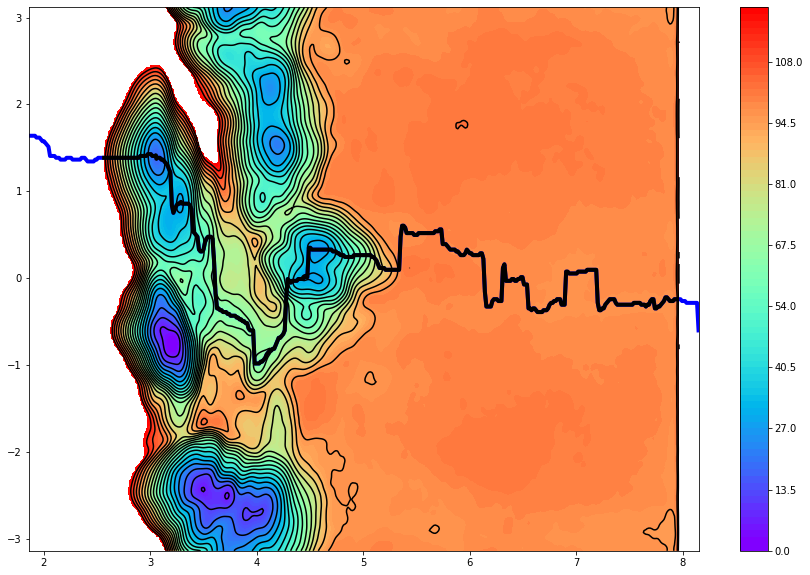

In [57]:
#Plot the FES with the LEP
X, Y = np.meshgrid(dist_arr,tor_arr) #create grid for the plot

Z=np.stack(ener_arr) #create grid for contour levels
Z = np.ma.masked_where(Z > 120, Z) #mask unneeded levels, must be tuned
fig, ax = plt.subplots(figsize=(15,10)) #prepare the figure
cp = ax.contourf(X, Y, Z, levels = 80, cmap='rainbow', vmin= 2, vmax = 120, zorder=0) #add contours, parameters must be tuned accordingly
plt.contour(cp, levels = cp.levels[::4], colors='black', zorder=5) #plot contour, tuning may be needed
cbar = fig.colorbar(cp) #add color bar as reference for contour

#Plot the LEPs
plt.plot(LEPx[:], LEPy[:], linewidth=4, color='b') #this is an example of what may happen when the walker starts from zero and no interval is given
plt.plot(LEPx[50:-15], LEPy[50:-15], linewidth=4, color='k') #the interval of the LEP to plot (here points from 50 to -15) may be changed as needed

In [58]:
#Example of how to extract structures from a dummy LEP

LEP_test = [[2.,2.],[1.,1.],[-1.,-1.]]
folder = '/storage2/smotta/CITOCHINE/test/'
plumed_dir = '/apps/plumed2.7.0_static/bin/plumed'
dat = folder + 'driver_dumpAtoms.dat'
traj='walker1_noW3.xtc'
atoms = '1105'
pdb = 'driver.pdb'
coord_max = '1.73,-1.07'
coord_min = '1.62,-1.42'
out_name ='min.gro'
binning = [0.5,0.2]
run_plumed(folder,plumed_dir,dat,traj,atoms,pdb,LEP_test,coord_min,coord_max,out_name,binning) 
    

No protocol specified


PLUMED:                                               Cycles        Total      Average      Minimum      Maximum
PLUMED:                                                    1    36.537530    36.537530    36.537530    36.537530
PLUMED: 1 Prepare dependencies                        900001     0.349426     0.000000     0.000000     0.000028
PLUMED: 2 Sharing data                                900001     3.293197     0.000004     0.000003     0.000291
PLUMED: 3 Waiting for data                            900001     0.221979     0.000000     0.000000     0.000022
PLUMED: 4 Calculating (forward loop)                  900001    13.923394     0.000015     0.000014     0.000202
PLUMED: 5 Applying (backward loop)                    900001     8.870863     0.000010     0.000009     0.000246
PLUMED: 6 Update                                      900001     7.339259     0.000008     0.000000     1.573488


No protocol specified
No protocol specified
